# BAP1 cis comparison


BAP1 is known as a tumor suppressor and a deubiquitinase. "The presence of ubiquitin molecules on a protein can affect the activity of the protein and its interactions with other proteins. The ubiquitin "tag" also promotes breakdown (degradation) of a protein. By removing ubiquitin, BAP1 helps regulate the function of many proteins involved in diverse cellular processes. The BAP1 protein is thought to help control cell growth and division (proliferation) and cell death" (https://ghr.nlm.nih.gov/gene/BAP1).

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import re
import sys 
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsMatter\\Brittany\\')
import functions as f

import cptac
import cptac.algorithms as al

In [66]:
def wrap_ttest(df, label_column, comparison_columns, alpha=.05, verbose=False):
    '''Verify precondition that label column exists and has exactly 2 unique values'''
    label_values = df[label_column].unique()
    if len(label_values) != 2:
        print("Incorrectly Formatted Dataframe! Label column must have exactly 2 unique values.")
        return None

    '''Partition dataframe into two sets, one for each of the two unique values from the label column'''
    partition1 = df.loc[df[label_column] == label_values[0]]
    partition2 = df.loc[df[label_column] == label_values[1]]

    '''Determine the number of real valued columns on which we will do t-tests'''
    number_of_comparisons = len(comparison_columns)

    '''Use a bonferroni correction to adjust for multiple testing by altering the p-value needed for acceptance'''
    bonferroni_cutoff = alpha/number_of_comparisons

    '''Store significant comparisons with their p-values in a dictionary'''
    significant_comparisons = {}

    '''Loop through each comparison column, perform the t-test, and determine whether it meets the significance cutoff'''
    for column in comparison_columns:
        stat, pval = scipy.stats.ttest_ind(partition1[column].dropna(axis=0), partition2[column].dropna(axis=0))
        
        if verbose:
            print(column, ": ", pval)
        print(pval)
        if pval <= bonferroni_cutoff:
            significant_comparisons[column] = pval

    '''If no comparison met the significance cutoff, notify that no comparison was signficant, and return None'''
    if len(significant_comparisons) == 0:
        print("No significant comparisons.")
        return None

        '''If one or more comparison did meet the significance cutoff, sort the dictionary by significance and return it to the caller'''
    else:
        sorted_significant_comparisons = sorted(significant_comparisons.items(), key=lambda kv: kv[1])
        return sorted_significant_comparisons

    

## Step 2: Find the mutation frequency of BAP1 for Kidney Cancer

In [33]:
rc = cptac.RenalCcrcc()
desired_cutoff = 0.1
gene = 'BAP1'

freq_mut = al.get_frequently_mutated(rc, cutoff = desired_cutoff)
freq_mut.loc[freq_mut['Gene'] == gene]

,Gene,Unique_Samples_Mut,Missense_Mut,Truncation_Mut
0,BAP1,0.154545,0.063636,0.090909


## Step 3: cis comparisons for omics 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data does the first 3 steps.

# Proteomics cis comparison

Proteomics: Mutated and Wildtype

In [34]:
prot_mut_status = f.format_cis_comparison_data(rc, 'proteomics', gene)

prot_col_list = [gene+'_proteomics']
prot_col = gene+"_proteomics"

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison\n")
prot_pval_results = al.wrap_ttest(prot_mut_status, 'binary_mutations', prot_col_list)

Doing t-test comparison



In [37]:
total_tests = len(freq_mut)

In [41]:
# make function just for cis?

def add_significance_col(results_df, num_comparisons):
    # bonferroni multiple hypothesis 
    alpha = .05
    bonferroni_cutoff = alpha / num_comparisons
    try:
        pval = results_df['P_Value']
        if pval[0] <= bonferroni_cutoff:
            results_df['Significant'] = True
        else: 
            results_df['Significant'] = False
        return results_df
    except:
        return None

In [42]:
add_significance_col(prot_pval_results, total_tests)

,Comparison,P_Value,Significant
0,BAP1_proteomics,0.010487,False


This p-value is not significant because of multiple hypothesis testing. Other notebooks test the rest of the frequently mutated genes. 

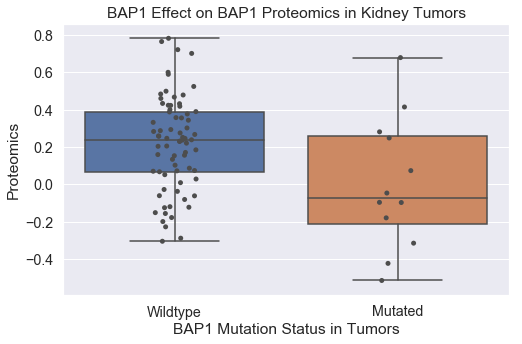

In [39]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.3)
cis_boxplot = sns.boxplot(data = prot_mut_status, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene + " Proteomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data= prot_mut_status, x = 'binary_mutations',
                            y = prot_col,jitter = True, color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels())
plt.show()
plt.clf()
plt.close()

Proteomics: Missense and Truncation compared to wildtype

In [44]:
prot_mut_type = f.get_missense_truncation_comparison(rc, 'proteomics', gene)
prot_wildtype = prot_mut_status.loc[prot_mut_status['binary_mutations'] == 'Wildtype'] # select all wildtype from binary_mutations
prot_mut_and_wildtype = prot_mut_type.append(prot_wildtype, sort=False) # use for graph

# compare missense and wildtype
prot_miss_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
prot_results_miss = al.wrap_ttest(prot_miss_wt, 'binary_mutations', prot_col_list)
add_significance_col(prot_results_miss, total_tests)

# compare truncation and wildtype
prot_trunc_wt = prot_mut_and_wildtype.loc[prot_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
prot_results_trunc = al.wrap_ttest(prot_trunc_wt, 'binary_mutations', prot_col_list)
add_significance_col(prot_results_trunc, total_tests)

Doing t-test comparison for missense and wildtype

No significant comparisons.


Doing t-test comparison for truncation and wildtype



,Comparison,P_Value,Significant
0,BAP1_proteomics,0.004736,True


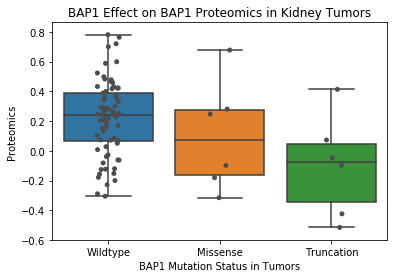

In [45]:
prot_cis_boxplot = sns.boxplot(data = prot_mut_and_wildtype, x = 'binary_mutations',
                          y = prot_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
prot_cis_boxplot.set_title(gene + " Effect on "+gene+" Proteomics in Kidney Tumors")
prot_cis_boxplot = sns.stripplot(data= prot_mut_and_wildtype, x = 'binary_mutations',
                            y = prot_col, jitter = True, color = ".3", order = ["Wildtype","Missense","Truncation"])
prot_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

# Transcriptomics cis comparison

Transcriptomics: Mutated and Wildtype

In [52]:
trans_mut_status = f.format_cis_comparison_data(rc, 'transcriptomics', gene)

trans_col_list = [gene+'_transcriptomics']

print("Doing t-test comparison for mutation status\n")
trans_pval_results = al.wrap_ttest(trans_mut_status, 'binary_mutations', trans_col_list)
add_significance_col(prot_results_trunc, total_tests)

Doing t-test comparison for mutation status



,Comparison,P_Value,Significant
0,BAP1_proteomics,0.004736,True


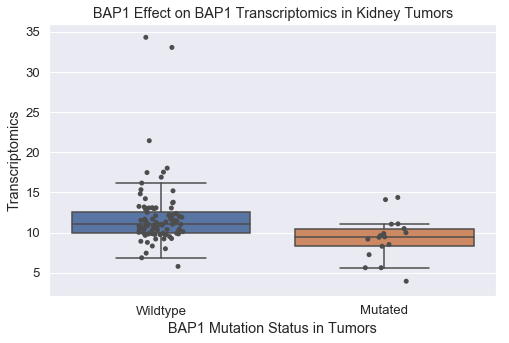

In [48]:
trans_col = gene+'_transcriptomics'

plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
cis_boxplot = sns.boxplot(data = trans_mut_status, x = 'binary_mutations',
                          y = trans_col, order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors")
cis_boxplot = sns.stripplot(data = trans_mut_status, x = 'binary_mutations',y = trans_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Transcriptomics")
plt.show()
plt.clf()
plt.close()

Transcriptomics: Missense and Truncation

In [49]:
# select all wildtype from earlier -add to mut_type binary column
trans_wildtype = trans_mut_status.loc[trans_mut_status['binary_mutations'] == 'Wildtype'] 
trans_mut_type = f.get_missense_truncation_comparison(rc, 'transcriptomics', gene)
trans_mut_and_wildtype = trans_mut_type.append(trans_wildtype, sort=False) # use for graph


trans_col_list = [gene+'_transcriptomics']
# compare missense and wildtype
miss_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
results_trans_miss = al.wrap_ttest(miss_wt, 'binary_mutations', trans_col_list)
add_significance_col(results_trans_miss, total_tests)

Doing t-test comparison for missense and wildtype

No significant comparisons.


In [51]:
# compare truncation and wildtype
trunc_wt = trans_mut_and_wildtype.loc[trans_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
results_prot_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', trans_col_list)
add_significance_col(prot_results_trunc, total_tests)



Doing t-test comparison for truncation and wildtype



,Comparison,P_Value,Significant
0,BAP1_proteomics,0.004736,True


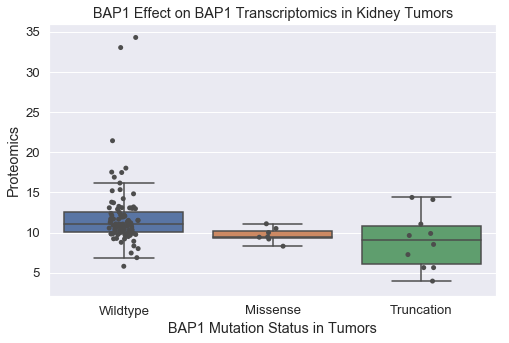

In [19]:
plt.rcParams['figure.figsize']=(8,5)
sns.set(font_scale = 1.2)
trans_cis_boxplot = sns.boxplot(data = trans_mut_and_wildtype, x = 'binary_mutations',
                          y = trans_col, order = ["Wildtype","Missense","Truncation"], showfliers = False)  
trans_cis_boxplot.set_title(gene + " Effect on " + gene +" Transcriptomics in Kidney Tumors")
trans_cis_boxplot = sns.stripplot(data = trans_mut_and_wildtype, x = 'binary_mutations',y = trans_col, jitter = True, 
                        color = ".3", order = ["Wildtype","Missense","Truncation"])
trans_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()
plt.clf()
plt.close()

# Phosphoproteomics cis comparison

Phosphoproteomics: Mutated and Wildtype

In [68]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
omics_and_mut = rc.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'phosphoproteomics', omics_genes = gene)

# Step 2 - Create the binary column needed to do the comparison
omics_and_mut['binary_mutations'] = omics_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
omics_and_mut = omics_and_mut.query('Sample_Status != "Normal"') # changed because warning with slice
#tumors = omics_and_mut.loc[omics_and_mut['Sample_Status'] == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
binary_phospho = omics_and_mut.drop(columns_to_drop, axis = 1)
only_phospho = binary_phospho.drop('binary_mutations', axis = 1)
binary_phospho['binary_mutations'].value_counts()
binary_phospho[['BAP1-S292_phosphoproteomics','binary_mutations']].dropna(axis=0)
binary_phospho
# 2 col BAP1-S325_phosphoproteomics

,BAP1-S292_phosphoproteomics,BAP1-S319_phosphoproteomics,BAP1-S325_phosphoproteomics,BAP1-S395_phosphoproteomics,BAP1-S395_phosphoproteomics,BAP1-S521_phosphoproteomics,BAP1-S525_phosphoproteomics,BAP1-S583_phosphoproteomics,BAP1-S583S597_phosphoproteomics,BAP1-S595_phosphoproteomics,BAP1-S596_phosphoproteomics,BAP1-S596S597_phosphoproteomics,BAP1-S597_phosphoproteomics,BAP1-T517_phosphoproteomics,BAP1-T517S521_phosphoproteomics,BAP1-Y401_phosphoproteomics,BAP1-Y401_phosphoproteomics,binary_mutations
Sample_ID,,,,,,,,,,,,,,,,,,
S001,NaN,NaN,0.048291,-0.166761,NaN,0.196557,0.285886,NaN,0.253342,NaN,NaN,0.179115,0.170839,NaN,NaN,NaN,NaN,Wildtype
S002,0.109062,NaN,NaN,NaN,NaN,NaN,NaN,0.148977,NaN,NaN,0.012016,NaN,NaN,NaN,NaN,NaN,NaN,Wildtype
S003,NaN,NaN,NaN,NaN,NaN,NaN,-0.273021,NaN,NaN,NaN,NaN,NaN,-0.313618,NaN,NaN,NaN,NaN,Mutated
S004,NaN,NaN,NaN,0.086001,0.034149,NaN,-0.510043,NaN,NaN,NaN,NaN,NaN,-0.254427,NaN,NaN,NaN,NaN,Wildtype
S005,NaN,NaN,NaN,0.010580,NaN,0.391156,0.368607,NaN,NaN,NaN,NaN,NaN,0.244575,NaN,NaN,-0.249279,NaN,Wildtype
S006,NaN,NaN,NaN,-0.041519,NaN,NaN,0.025493,NaN,NaN,NaN,NaN,NaN,0.048442,NaN,NaN,-0.220063,NaN,Wildtype
S007,NaN,NaN,NaN,NaN,NaN,NaN,0.304852,NaN,0.261759,NaN,NaN,NaN,0.289762,NaN,NaN,NaN,NaN,Wildtype
S008,NaN,NaN,0.222123,-0.084479,NaN,0.210930,0.287220,NaN,0.221323,NaN,NaN,0.198893,0.259029,NaN,NaN,NaN,NaN,Wildtype
S009,-0.045975,NaN,0.425614,NaN,0.214100,NaN,0.593596,NaN,NaN,NaN,NaN,NaN,0.077220,0.351537,NaN,NaN,NaN,Wildtype


In [67]:
phos_col_list = list(only_phospho.columns)

# Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
print("Doing t-test comparison for mutation status\n")
phos_pval_results = wrap_ttest(binary_phospho, 'binary_mutations', phos_col_list)
phos_pval_results

Doing t-test comparison for mutation status

nan
nan
0.004080224501165623
[0.13464363 0.55287666]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Graph

In [48]:
# Create data frame with all significant phospho sites in order to graph
phospho_list = list(only_phospho.columns)
phospho_df = pd.melt(binary_phospho, id_vars = 'binary_mutations', 
            value_vars = phospho_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phospho_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

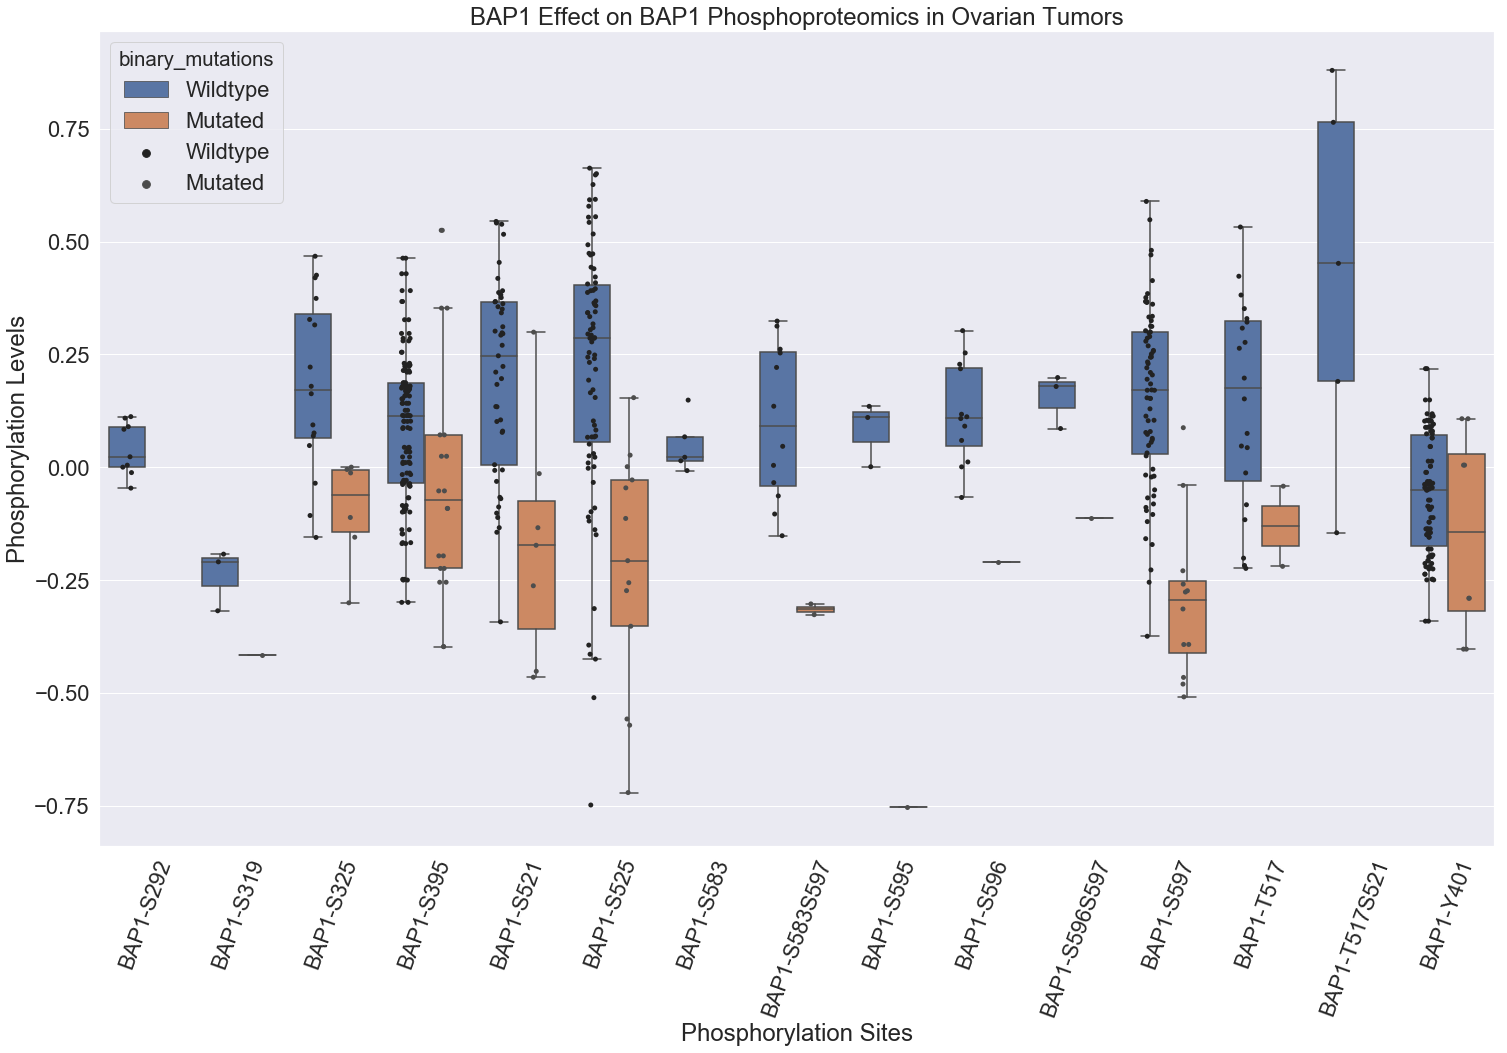

In [49]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
cis_boxplot = sns.boxplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Mutated"], showfliers = False)  
cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
cis_boxplot = sns.stripplot(data = phospho_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Mutated"], jitter = True, color = ".3", dodge = True)
cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
cis_boxplot.set_xticklabels(cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

Phosphoproteomics: Missense and Truncation

In [38]:
# select all wildtype from earlier -add to mut_type binary column
phos_wildtype = binary_phospho.loc[binary_phospho['binary_mutations'] == 'Wildtype'] 

phos_mut_type = f.get_missense_truncation_comparison(rc, 'phosphoproteomics', gene)
phos_mut_and_wildtype = phos_mut_type.append(phos_wildtype, sort=True) 

AssertionError: Number of manager items must equal union of block items
# manager items: 18, # tot_items: 22

In [31]:
phos_col_list = list(only_phospho.columns)
# compare missense and wildtype
miss_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Truncation']
print("Doing t-test comparison for missense and wildtype\n")
phos_results_miss = al.wrap_ttest(miss_wt, 'binary_mutations', phos_col_list)
print(phos_results_miss)

# compare truncation and wildtype 
trunc_wt = phos_mut_and_wildtype.loc[phos_mut_and_wildtype['binary_mutations'] != 'Missense']
print("\n\nDoing t-test comparison for truncation and wildtype\n")
phos_results_trunc = al.wrap_ttest(trunc_wt, 'binary_mutations', phos_col_list)
print(phos_results_trunc)

NameError: name 'phos_mut_and_wildtype' is not defined

Graph Missense and Truncation

In [30]:
# Create data frame with all significant phospho sites in order to graph
phos_mut_type_df = pd.melt(phos_mut_and_wildtype, id_vars = 'binary_mutations', 
            value_vars = phos_col_list, var_name = 'specific_phospho', value_name = 'phosphoproteomics')
phos_mut_type_df.replace(to_replace = '_phosphoproteomics', value = '', 
                        inplace = True, regex = True) # shorten column names
#sig_phospho_df.dropna(axis=0)

NameError: name 'phos_mut_and_wildtype' is not defined

In [29]:
plt.rcParams['figure.figsize']=(25,15) #size of plot
sns.set(font_scale = 2)
phos_cis_boxplot = sns.boxplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                             hue_order = ["Wildtype","Missense","Truncation"], showfliers = False)  
phos_cis_boxplot.set_title(gene + " Effect on " + gene + " Phosphoproteomics in Ovarian Tumors")
phos_cis_boxplot = sns.stripplot(data = phos_mut_type_df, x = 'specific_phospho', y = 'phosphoproteomics', hue = 'binary_mutations',
                               hue_order = ["Wildtype","Missense","Truncation"], jitter = True, color = ".3", dodge = True)
phos_cis_boxplot.set(xlabel = 'Phosphorylation Sites', ylabel = "Phosphorylation Levels")
phos_cis_boxplot.set_xticklabels(phos_cis_boxplot.get_xticklabels(),rotation = 70)
plt.show()
plt.clf()
plt.close()

NameError: name 'phos_mut_type_df' is not defined

#  Compare common mutations

Find the common mutation types and compare them to the wildtype tumors.

In [19]:
# Count all mutations (including all mutations in a sample)
somatic_mutations = ov.get_mutations()
gene_mutations = somatic_mutations.loc[somatic_mutations['Gene'] == gene]
count_all_mut = gene_mutations['Mutation'].value_counts()
count_all_mut


Missense_Mutation    10
Silent                1
Frame_Shift_Del       1
Nonsense_Mutation     1
Name: Mutation, dtype: int64

In [20]:
mut = 'Missense_Mutation'
gene_mutations.loc[gene_mutations['Mutation'] == mut]
#gene_mutations['Location'].value_counts()

,Gene,Mutation,Location
Sample_ID,,,
S016,BIRC6,Missense_Mutation,p.L70M
S016,BIRC6,Missense_Mutation,p.V3843F
S023,BIRC6,Missense_Mutation,p.A1264D
S043,BIRC6,Missense_Mutation,p.N2644K
S050,BIRC6,Missense_Mutation,p.A1584E
S080,BIRC6,Missense_Mutation,p.R3123I
S087,BIRC6,Missense_Mutation,p.S4275R
S095,BIRC6,Missense_Mutation,p.R3193C
S096,BIRC6,Missense_Mutation,p.P3775T


# Analysis of Results

No significant cis comparisons. Almost all mutations are missense mutations. Five of the ten missense are found in the UBC domain associated with ubiquitination (~3000-4000). (NIH)

No acetylproteomics for the ovarian dataset.

In [17]:
all_results = {"Mutated vs Wildtype": prot_pval_results}
r = pd.DataFrame.from_dict(all_results)

ValueError: If using all scalar values, you must pass an index